simaliar to the first attempt but with cleaner code, more flexible layer creation

In [43]:
import numpy as np
import math
import copy
from dataclasses import dataclass

print("start!")

@dataclass
class Config:
    input_layer_size: int
    output_layer_size: int
    hidden_layer_num : int
    hidden_layer_size : int

    dataset_size : int
    learning_rate :float
    batch_size : int
    epochs : int



start!


In [54]:
def create_layer(layer_size, dtype=np.float32, **kwargs):
    layer = np.zeros(layer_size, dtype=dtype)
    return(layer)

def create_layer_weights(prev_ly_size, curr_ly_size, init=True):
    if init:
        ly_weights = np.random.rand(prev_ly_size, curr_ly_size)
    else:
        ly_weights = np.zeros(shape=(prev_ly_size, curr_ly_size))
    return(ly_weights)

def create_biases(ly_size, init=True):
    if init:
        biases = np.random.rand(ly_size)
    else:
        biases = np.zeros(ly_size)
    return(biases)


def label_to_output(int) -> np.ndarray:
    outlayer = np.zeros(shape=(10), dtype=np.float32)
    outlayer[int] = 1
    return(outlayer)

def label_vec_to_output(inputs: np.ndarray) -> np.ndarray:
    # Create an identity matrix of size 10 and index into it
    return np.eye(10, dtype=np.int8)[inputs]

class n_network:
    def __init__(self, layers, z_layers, biases, weights):
        self.layers = layers
        self.z_layers = z_layers
        self.biases = biases
        self.weights = weights

def create_network(in_ly_size, out_ly_size, hidden_ly_num, hidden_ly_size):
    in_layer = create_layer(in_ly_size)
    hidden_lys = []
    for index in range(hidden_ly_num):
        hidden_lys.append(create_layer(hidden_ly_size))
    out_layer = create_layer(out_ly_size)
    network_lys = [in_layer, *hidden_lys, out_layer]


    biases =[]
    for i in range(1, len(network_lys), 1):
        biases.append(create_biases(np.size(network_lys[i]), init=False))

    weights = []
    for i in range(1, len(network_lys), 1):
        weights.append( create_layer_weights(np.size(network_lys[i-1]), np.size(network_lys[i]), init=True))

    z_layers = deep_copy_mat_list(network_lys, False)

    network = n_network(network_lys, z_layers, biases, weights)
    return(network)


def sigx(number):
    #sigmond function
    #todo: make a nativly vectorized verison of this 
    try:
        sig_x = ( 1 / (1+ math.exp(-number)))
        #this does not woprk for large negitive numbers 
        # due to rounding errors leading to devide by zero so we'll add error handling
    except OverflowError:
        sig_x = 0
    return(sig_x)

def sigmond(input):
    #a more easily vectorizable sigmond function
    return( 1/(1+np.exp(-input)))

def sigmond_prime(input):

    return(sigmond(input) * (1-sigmond(input)))

def forward(input_vals:np.ndarray, net:n_network):
    #first layer
    input_vals = np.array(input_vals)
    net.layers[0] = input_vals

    for index in range(1, len(net.layers), 1):
        net.layers[index] = np.dot(net.layers[(index-1)], net.weights[index-1]) + net.biases[index-1]
        
        #activation function
        net.layers[index] = sigmond(net.layers[index])
    return(net)

def node_delta(expected:np.array, actual:np.array):
    delta = expected - actual
    return(delta)

def deep_copy_mat_list (list_to_copy, propigate_cell_vals=True):
    #creates a copy of a list containing numpy arrays of varible size, ethier as empty arrays or with the same values
    
    new_list = []
    if propigate_cell_vals:
        for items in list_to_copy:
            new_list.append(items)
    else:
        for items in list_to_copy:
            new_list.append(np.zeros_like(items))       

    return(new_list)


def loss(network_output_ly, expected_ly):
    #loss =  mean of all output neurons - the expected, squared
    loss_vec = ((network_output_ly - expected_ly)**2) / 2
    loss_sclr = np.sum((network_output_ly - expected_ly)**2)
    return(loss_sclr, loss_vec)

def backprop_single(net: n_network, expected_out_ly):
    #does backprop for a single training example, duhh
    #add learning rate??
    
    expected_out_ly = np.array(expected_out_ly)
    w_delta = deep_copy_mat_list(net.weights, propigate_cell_vals=False)
    b_delta = deep_copy_mat_list(net.biases, propigate_cell_vals=False)
    a_error = deep_copy_mat_list(net.layers, propigate_cell_vals=False)

    first = True
    for l in range(len(net.layers)-1, 0, -1):
        w = l - 1
        #print("l: ", l, "w: ", w)

        if first:
            #first(last) layer
            first = False
            a_delta_dir = expected_out_ly - net.layers[l]
            #print("a_delta_dir: ", len(a_delta_dir))
            a_error[l] = a_delta_dir * sigmond_prime(net.z_layers[l])
            #print("a_error_of l: ", len(a_error[l]))

            a_error[l-1] = np.dot((net.weights[w]) , a_error[l]) * sigmond_prime(net.z_layers[l-1])
            #print("a_error_of l-1: ", a_error[l-1].shape)

            w_delta[w] =  np.outer(net.layers[l-1], a_error[l])
            #print("w_delta of w: ", np.shape(w_delta[w]), np.shape(net.weights[w]))

            b_delta[w] = a_error[w]

        else:

            a_error[l] = np.dot((net.weights[w+1]) , a_error[l+1]) * sigmond_prime(net.z_layers[l])
            w_delta[w] =  np.outer(net.layers[l-1], a_error[l])
            b_delta[w] = a_error[w]
            #print("shape of b_delta: ", np.shape(b_delta[w]))

    return(w_delta, b_delta)

def backprop_single_OLD(net: n_network, expected_out_ly):
    #does backprop for a single training example, duhh
    #add learning rate??
    
    expected_out_ly = np.array(expected_out_ly)
    w_delta = deep_copy_mat_list(net.weights, propigate_cell_vals=False)
    b_delta = deep_copy_mat_list(net.biases, propigate_cell_vals=False)
    a_delta = deep_copy_mat_list(net.layers, propigate_cell_vals=False)

    first = True
    for l in range(len(net.layers)-1, 0, -1):
        #print("at l of:", l)

        if first:
            #first(last) layer
            first = False
            a_delta_dir = expected_out_ly - net.layers[l]  
            w_delta[l-1] = np.outer(net.layers[l-1], a_delta_dir)   
            a_delta[l] = a_delta_dir
        else:
            a_delta_dir = a_delta[l] - net.layers[l]
            w_delta[l-1] = np.outer(net.layers[l-1], a_delta_dir)   

        a_delta[l-1] = np.dot(net.weights[l-1], net.layers[l])
        a_delta[l-1] = a_delta[l-1] / a_delta[l-1].size
    return(w_delta, b_delta)

def create_batch(cfg:Config, batch_position, image_file, label_file):
   
    image_buffer = image_file.read(cfg.input_layer_size * cfg.batch_size)
    input_batch = np.frombuffer(image_buffer, dtype=np.uint8).astype(np.float32)
    input_batch = input_batch.reshape(cfg.batch_size, cfg.input_layer_size)
    
    label_buffer = label_file.read(cfg.batch_size)
    label_batch = np.frombuffer(label_buffer, dtype=np.uint8).astype(np.int64)
    Label_batch = label_vec_to_output(label_batch)

    return(input_batch, Label_batch)
    
def batch_learning(input_batch:np.ndarray, desired_output_batch:np.ndarray, net:n_network, cfg:Config):
    cfg.batch_size
    w_del_batch = []
    b_del_batch = []
    batch_loss = np.ndarray((cfg.batch_size,))

    for layers in net.weights:
        w_del_batch.append(np.zeros((cfg.batch_size,) + layers.shape, dtype=np.float32)  )


    for batch in range(cfg.batch_size):
        net = forward(input_batch[batch], net)
        w_del_batch_tmp, b_del_batch_tmp = backprop_single(net, desired_output_batch[batch])

        for layer_num in range(cfg.hidden_layer_num +1):   
            w_del_batch[layer_num][batch,:,:] = w_del_batch_tmp[layer_num]
        
        loss_sclr, loss_vec = loss(net.layers[-1], desired_output_batch[batch])
        batch_loss[batch] = loss_sclr
    batch_loss = np.mean(batch_loss)
    print("batch_loss: ",batch_loss)



    w_delta_mean = deep_copy_mat_list(net.weights, False)
    for layer_num in range(cfg.hidden_layer_num +1):   
        w_delta_mean[layer_num] = np.mean(w_del_batch[layer_num], axis=0) * cfg.learning_rate #learning rate is here!
    #    print(w_delta_mean[layer_num].shape)
    #print("W_delta array: \n")
    #for layers in w_delta_mean:
    #    print(layers.shape)
    #    print(layers)


    b_delta_mean = []
    descent_step = w_delta_mean, b_delta_mean
    return(descent_step)

def train(images_pth, labels_pth, cfg:Config):

    net = create_network(cfg.input_layer_size, cfg.output_layer_size, cfg.hidden_layer_num, cfg.hidden_layer_size)

    for epoch in range(cfg.epochs):
        print("epoch ", int(epoch), "out of ", int(cfg.epochs))
        f = open(images_pth, 'rb')
        f.read(16)
        l = open(labels_pth,'rb')
        l.read(8)
        for index in range(0, cfg.dataset_size, cfg.batch_size):
            #print("index position: ", int(index))
            input_ly, label_ly = create_batch(cfg, index, f, l)
            #batch_learning(input_ly, label_ly, net,cfg)
            W_delta, B_delta = batch_learning(input_ly, label_ly, net,cfg)
            for layer_num in range(cfg.hidden_layer_num +1):   
                net.weights[layer_num] = net.weights[layer_num] + W_delta[layer_num]



    #do batches here:
    return(net)    


In [55]:
image_size = 28**2
batch_size = 100
dataset_size = 60000
hidden_layers = 3
hidden_layer_size = 17
learning_rate = 1
epochs = 2
images_path = "MNIST/train-images.idx3-ubyte"
labels_path = "MNIST/train-labels.idx1-ubyte"

cfg = Config(input_layer_size=image_size,
              output_layer_size=10,
              hidden_layer_num= hidden_layers,
              hidden_layer_size = hidden_layer_size,
              
              learning_rate=learning_rate,
              dataset_size=dataset_size,
              batch_size=batch_size,
              epochs=epochs
              )


net = train(images_path, labels_path, cfg=cfg)
weights_layer_1 = net.weights[0]
weights_layer_2 = net.weights[1]
weights_layer_3 = net.weights[2]
weights_layer_4 = net.weights[3]




epoch  0 out of  2
batch_loss:  8.990142413134784
batch_loss:  8.245562108736628
batch_loss:  4.133542436641566
batch_loss:  1.609149983781368
batch_loss:  1.0900382119216123
batch_loss:  0.9612034147287717
batch_loss:  0.9270294938734607
batch_loss:  0.9188776842276262
batch_loss:  0.9075254138642751
batch_loss:  0.9026539549916797
batch_loss:  0.900931371184819
batch_loss:  0.9005759876907713
batch_loss:  0.9018424987788448
batch_loss:  0.9036397908263892
batch_loss:  0.9013072895759422
batch_loss:  0.901671850710231
batch_loss:  0.8988288486830354
batch_loss:  0.9031964513506435
batch_loss:  0.8989729388245203
batch_loss:  0.8997119355285786


/tmp/ipykernel_6921/3681864672.py:72: RuntimeWarning: overflow encountered in exp
  return( 1/(1+np.exp(-input)))


batch_loss:  0.9028062237079085
batch_loss:  0.8999737360456759
batch_loss:  0.8991290544515477
batch_loss:  0.9034602743189393
batch_loss:  0.8964940185521768
batch_loss:  0.9024670079826045
batch_loss:  0.9032505358810786
batch_loss:  0.9004098064992475
batch_loss:  0.8969309872181515
batch_loss:  0.9030005895140489
batch_loss:  0.9059176073184538
batch_loss:  0.8999592472999209
batch_loss:  0.9027090472674874
batch_loss:  0.9017650253713108
batch_loss:  0.9014809377873259
batch_loss:  0.9020552386345174
batch_loss:  0.9022325510764175
batch_loss:  0.9004966730223807
batch_loss:  0.9005339353999147
batch_loss:  0.8990840367440731
batch_loss:  0.8993718807473126
batch_loss:  0.9027199127892844
batch_loss:  0.9021087567862865
batch_loss:  0.8984005670529115
batch_loss:  0.904453106677891
batch_loss:  0.8988506328296759
batch_loss:  0.9039762814150446
batch_loss:  0.8998714321638198
batch_loss:  0.8986677022153059
batch_loss:  0.9006803671432259
batch_loss:  0.8999892554435762
batch_los

KeyboardInterrupt: 

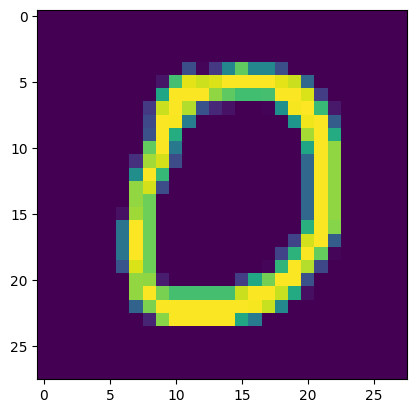

0
[0.09540138 0.10369053 0.10256694 0.10163326 0.09941897 0.08973942
 0.10664583 0.10665082 0.09521669 0.09856967]


In [52]:
f = open("MNIST/t10k-images.idx3-ubyte", 'rb')

image_size = 28
num_images = 50
choice = 10

try:
    f.read(16)
except UnicodeDecodeError as error:
    print(error)
    print("utf-8 error is usally due to binary format")


buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
batch = data.reshape(num_images, 28*28)
data = data.reshape(num_images, image_size, image_size, 1)

import matplotlib.pyplot as plt
image = np.asarray(data[choice]).squeeze()
plt.imshow(image)
plt.show()

l = open("MNIST/t10k-labels.idx1-ubyte",'rb')
l.read(8)
buf = l.read(10000)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(labels[choice])

inlayer = batch[choice]
net = forward(inlayer, net)
print(net.layers[-1])



In [ ]:
net = create_network(3,5,1,2)
input = [1,1,1]
output = [0,1,0,1,0]

net.weights[1] = np.transpose(np.array([[0,0],
                           [0.5,0.5],
                           [0.3,-1],
                           [0.3,-1],
                           [0.1,0.1]]))
net.weights[0] = (np.array([[1,1],
                           [0.5,0.5],
                           [0.3,-1]]))
print(np.shape(net.weights[1]))

net = forward(input,net)
w_delta, b_delta = backprop_single(net, output)


(2, 5)


In [ ]:
net = create_network(3,5,2,7)
input = [1,1,1]
output = [0,1,0,1,0]

net = forward(input,net)
w_delta, b_delta = backprop_single(net, output)